In [1]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from math import log2
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [2]:
!unzip "/content/archive.zip"

Streaming output truncated to the last 5000 lines.
  inflating: clothes/013569_1.jpg    
  inflating: clothes/013570_1.jpg    
  inflating: clothes/013571_1.jpg    
  inflating: clothes/013572_1.jpg    
  inflating: clothes/013573_1.jpg    
  inflating: clothes/013574_1.jpg    
  inflating: clothes/013575_1.jpg    
  inflating: clothes/013576_1.jpg    
  inflating: clothes/013577_1.jpg    
  inflating: clothes/013579_1.jpg    
  inflating: clothes/013581_1.jpg    
  inflating: clothes/013583_1.jpg    
  inflating: clothes/013585_1.jpg    
  inflating: clothes/013586_1.jpg    
  inflating: clothes/013587_1.jpg    
  inflating: clothes/013588_1.jpg    
  inflating: clothes/013589_1.jpg    
  inflating: clothes/013590_1.jpg    
  inflating: clothes/013591_1.jpg    
  inflating: clothes/013593_1.jpg    
  inflating: clothes/013594_1.jpg    
  inflating: clothes/013595_1.jpg    
  inflating: clothes/013596_1.jpg    
  inflating: clothes/013597_1.jpg    
  inflating: clothes/013598_1.jpg    

In [3]:
DATA_SET = "/content/stylegan_clothes"
START_TRAIN_IMG_SIZE = 4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
BATCH_SIZES = [256,256,128,64,32,16]
LR = 1e-3
CHANNELS = 3
Z_Dim = 512
W_Dim = 512
IN_CHANNELS = 512
LAMBDA_GP = 10
PROGRESSIVE_EPOCHS = [30] * len(BATCH_SIZES)

In [24]:
def get_loader(image_size):
  trainsform = transforms.Compose([
      transforms.Resize([image_size, image_size]),
      transforms.ToTensor(),
      transforms.RandomHorizontalFlip(p=0.5),
      transforms.Normalize(
          [0.5 for _ in range(CHANNELS)],
          [0.5 for _ in range(CHANNELS)]
      )
  ])
  batch_size = BATCH_SIZES[int(log2(image_size/4))]
  dataset = datasets.ImageFolder(root=DATA_SET, transform = trainsform)
  loader = DataLoader(
      dataset,
      batch_size = batch_size,
      shuffle = True,
  )
  return loader, dataset

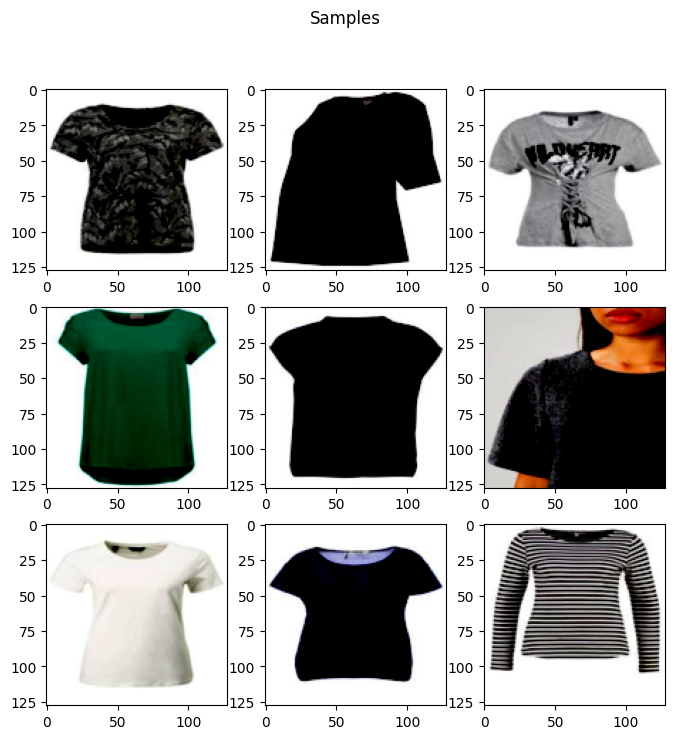

In [26]:
def check_loader():
  loader, _ = get_loader(128)
  cloth, _ = next(iter(loader))
  _, ax = plt.subplots(3,3, figsize = (8,8))
  plt.suptitle('Samples')
  ind = 0
  for i in range(3):
    for j in range(3):
      ax[i,j].imshow(cloth[ind].permute(1,2,0))
      ind += 1

check_loader()

In [6]:
factors = [1,1,1,1/2,1/4,1/8,1/16,1/32]

In [7]:
class WSLinear(nn.Module):
  def __init__(self, in_features, out_features):
    super(WSLinear,self).__init__()
    self.linear = nn.Linear(in_features, out_features)
    self.scale = (2/in_features) ** 0.5
    self.bias = self.linear.bias
    self.linear.bias = None

    nn.init.normal_(self.linear.weight)
    nn.init.zeros_(self.bias)

  def forward(self, x):
    return self.linear(x * self.scale) + self.bias

In [8]:
class PixelNorm(nn.Module):
  def __init__(self):
    super(PixelNorm, self).__init__()
    self.epsilon = 1e-8

  def forward(self, x):
    return x / torch.sqrt(torch.mean(x**2, dim = 1, keepdim = True)+ self.epsilon)

In [28]:
class MappingNetwork(nn.Module):
  def __init__(self, z_dim, w_dim):
    super().__init__()
    self.mapping = nn.Sequential(
        PixelNorm(),
        WSLinear(z_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
        WSLinear(w_dim, w_dim),
        nn.ReLU(),
    )

  def forward(self, x):
      return self.mapping(x)

In [42]:
class AdaIN(nn.Module):
  def __init__(self, channels, w_dim):
    super().__init__()
    self.instance_norm = nn.InstanceNorm2d(channels)
    self.style_scale_transform = WSLinear(w_dim, channels)
    self.style_shift_transform = WSLinear(w_dim, channels)

  def forward(self, x, w):
    x = self.instance_norm(x)
    style_scale = self.style_scale_transform(w).unsqueeze(2).unsqueeze(3)
    style_shift = self.style_shift_transform(w).unsqueeze(2).unsqueeze(3)
    return style_scale * x + style_shift

In [30]:
class injectNoise(nn.Module):
  def __init__(self,channels):
    super().__init__()
    self.weight = nn.Parameter(torch.zeros(1,channels,1,1))

  def forward(self, x):
    noise = torch.randn((x.shape[0], 1, x.shape[2], x.shape[3]), device = x.device)
    return x + self.weight * noise

In [31]:
class GenBlock(nn.Module):
  def __init__(self, in_channel, out_channel, w_dim):
    super(GenBlock, self).__init__()
    self.conv1 = WSConv2d(in_channel, out_channel)
    self.conv2 = WSConv2d(out_channel, out_channel)
    self.leaky = nn.LeakyReLU(0.2, inplace = True)
    self.inject_noise1 = injectNoise(out_channel)
    self.inject_noise2 = injectNoise(out_channel)
    self.adain1 = AdaIN(out_channel, w_dim)
    self.adain2 = AdaIN(out_channel, w_dim)

  def forward(self, x,w):
    x = self.adain1(self.leaky(self.inject_noise1(self.conv1(x))), w)
    x = self.adain2(self.leaky(self.inject_noise2(self.conv2(x))), w)
    return x

In [32]:
class Generator(nn.Module):
  def __init__(self, z_dim, w_dim, in_channels, img_channels = 3):
    super().__init__()
    self.starting_cte = nn.Parameter(torch.ones(1, in_channels, 4, 4))
    self.map = MappingNetwork(z_dim, w_dim)
    self.initial_adain1 = AdaIN(in_channels, w_dim)
    self.initial_adain2 = AdaIN(in_channels, w_dim)
    self.initial_noise1 = injectNoise(in_channels)
    self.initial_noise2 = injectNoise(in_channels)
    self.initial_conv = nn.Conv2d(in_channels, in_channels, kernel_size = 3, stride = 1, padding = 1)
    self.leaky = nn.LeakyReLU(0.2, inplace = True)

    self.initial_rgb = WSConv2d(in_channels, img_channels, kernel_size = 1, stride = 1, padding = 0)
    self.prog_blocks, self.rgb_layers = (nn.ModuleList([]), nn.ModuleList([self.initial_rgb]))

    for i in range(len(factors)-1):
      conv_in_c = int(in_channels * factors[i])
      conv_out_c = int(in_channels * factors[i+1])
      self.prog_blocks.append(GenBlock(conv_in_c, conv_out_c, w_dim))
      self.rgb_layers.append(WSConv2d(conv_out_c, img_channels, kernel_size = 1, stride = 1, padding = 0))

  def fade_in(self, alpha, upscaled, generated):
      return torch.tanh(alpha * generated + (1 - alpha) * upscaled)

  def forward(self, noise, alpha, steps):
      w = self.map(noise)
      x = self.initial_adain1(self.initial_noise1(self.starting_cte), w)
      x = self.initial_conv(x)
      out = self.initial_adain2(self.leaky(self.initial_noise2(x)),w)
      if steps == 0:
        return self.initial_rgb(out)
      for step in range(steps):
        upscaled = F.interpolate(out, scale_factor = 2, mode = 'bilinear')
        out = self.prog_blocks[step](upscaled, w)

      final_upscaled = self.rgb_layers[steps-1](upscaled)
      final_out = self.rgb_layers[steps](out)

      return self.fade_in(alpha, final_upscaled, final_out)

In [35]:
class WSConv2d(nn.Module):
  def __init__(self, in_channels, out_channels, kernel_size = 3, stride = 1, padding=1):
    super(WSConv2d, self).__init__()
    self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
    self.scale = (2/(in_channels * (kernel_size ** 2))) ** 0.5
    self.bias = self.conv.bias
    self.conv.bias = None

    nn.init.normal_(self.conv.weight)
    nn.init.zeros_(self.bias)

  def forward(self, x):
    return self.conv(x * self.scale) + self.bias.view(1, self.bias.shape[0], 1, 1)

In [36]:
class ConvBlock(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(ConvBlock, self).__init__()
    self.conv1 = WSConv2d(in_channels, out_channels)
    self.conv2 = WSConv2d(out_channels, out_channels)
    self.leaky = nn.LeakyReLU(0.2, inplace = True)

  def forward(self, x):
    x = self.leaky(self.conv1(x))
    x = self.leaky(self.conv2(x))
    return x

In [37]:
class Discriminator(nn.Module):
    def __init__(self, in_channels, img_channels=3):
        super(Discriminator, self).__init__()
        self.prog_blocks, self.rgb_layers = nn.ModuleList([]), nn.ModuleList([])
        self.leaky = nn.LeakyReLU(0.2)


        for i in range(len(factors) - 1, 0, -1):
            conv_in = int(in_channels * factors[i])
            conv_out = int(in_channels * factors[i - 1])
            self.prog_blocks.append(ConvBlock(conv_in, conv_out))
            self.rgb_layers.append(
                WSConv2d(img_channels, conv_in, kernel_size=1, stride=1, padding=0)
            )

        # perhaps confusing name "initial_rgb" this is just the RGB layer for 4x4 input size
        # did this to "mirror" the generator initial_rgb
        self.initial_rgb = WSConv2d(
            img_channels, in_channels, kernel_size=1, stride=1, padding=0
        )
        self.rgb_layers.append(self.initial_rgb)
        self.avg_pool = nn.AvgPool2d(
            kernel_size=2, stride=2
        )  # down sampling using avg pool

        # this is the block for 4x4 input size
        self.final_block = nn.Sequential(
            # +1 to in_channels because we concatenate from MiniBatch std
            WSConv2d(in_channels + 1, in_channels, kernel_size=3, padding=1),
            nn.LeakyReLU(0.2),
            WSConv2d(in_channels, in_channels, kernel_size=4, padding=0, stride=1),
            nn.LeakyReLU(0.2),
            WSConv2d(
                in_channels, 1, kernel_size=1, padding=0, stride=1
            ),  # we use this instead of linear layer
        )

    def fade_in(self, alpha, downscaled, out):
        """Used to fade in downscaled using avg pooling and output from CNN"""
        # alpha should be scalar within [0, 1], and upscale.shape == generated.shape
        return alpha * out + (1 - alpha) * downscaled

    def minibatch_std(self, x):
        batch_statistics = (
            torch.std(x, dim=0).mean().repeat(x.shape[0], 1, x.shape[2], x.shape[3])
        )

        return torch.cat([x, batch_statistics], dim=1)

    def forward(self, x, alpha, steps):

        cur_step = len(self.prog_blocks) - steps

        out = self.leaky(self.rgb_layers[cur_step](x))

        if steps == 0:  # i.e, image is 4x4
            out = self.minibatch_std(out)
            return self.final_block(out).view(out.shape[0], -1)

        downscaled = self.leaky(self.rgb_layers[cur_step + 1](self.avg_pool(x)))
        out = self.avg_pool(self.prog_blocks[cur_step](out))

        out = self.fade_in(alpha, downscaled, out)

        for step in range(cur_step + 1, len(self.prog_blocks)):
            out = self.prog_blocks[step](out)
            out = self.avg_pool(out)

        out = self.minibatch_std(out)
        return self.final_block(out).view(out.shape[0], -1)

In [44]:
def generate_examples(gen, steps, n=100):
  gen.eval()
  alpha = 1.0
  for i in range(n):
    with torch.no_grad():
      noise = torch.randn(1, Z_Dim).to(DEVICE)
      img = gen(noise, alpha, steps)
      if not os.path.exists(f'saved_examples/steps{steps}'):
        os.makedirs(f'saved_examples/steps{steps}')
      save_image(img * 0.5 + 0.5, f'saved_examples/steps{steps}/img{i}.png')
  gen.train()

In [45]:
def gradient_penalty(critic, real, fake, alpha, train_step, device="cpu"):
    BATCH_SIZE, C, H, W = real.shape
    beta = torch.rand((BATCH_SIZE, 1, 1, 1)).repeat(1, C, H, W).to(device)
    interpolated_images = real * beta + fake.detach() * (1 - beta)
    interpolated_images.requires_grad_(True)

    # Calculate critic scores
    mixed_scores = critic(interpolated_images, alpha, train_step)

    # Take the gradient of the scores with respect to the images
    gradient = torch.autograd.grad(
        inputs=interpolated_images,
        outputs=mixed_scores,
        grad_outputs=torch.ones_like(mixed_scores),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradient = gradient.view(gradient.shape[0], -1)
    gradient_norm = gradient.norm(2, dim=1)
    gradient_penalty = torch.mean((gradient_norm - 1) ** 2)
    return gradient_penalty

In [ ]:
def train_fn(critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen):
  loop = tqdm(loader, leave = True)

  for batch_idx, (real, _) in enumerate(loop):
    real = real.to(DEVICE)
    cur_batch_size = real.shape[0]
    noise = torch.randn(cur_batch_size, Z_Dim).to(DEVICE)
    fake  = gen(noise, alpha, step)
    critic_real = critic(real, alpha, step)
    critic_fake = critic(fake.detach(), alpha, step)
    gp = gradient_penalty(critic, real, fake, alpha, step, DEVICE)
    loss_critic = (
            -(torch.mean(critic_real) - torch.mean(critic_fake))
            + LAMBDA_GP * gp
            + (0.001) * torch.mean(critic_real ** 2)
        )
    critic.zero_grad()
    loss_critic.backward(retain_graph=True)
    opt_critic.step()

    gen_fake = critic(fake, alpha, step)
    loss_gen = -torch.mean(gen_fake)
    gen.zero_grad()
    loss_gen.backward()
    opt_gen.step()

    alpha += cur_batch_size / (
            (PROGRESSIVE_EPOCHS[step] * 0.5) * len(dataset)
        )
    alpha = min(alpha, 1)

    loop.set_postfix(
            gp=gp.item(),
            loss_critic=loss_critic.item(),
        )

  return alpha

In [47]:
gen = Generator(
    Z_Dim, W_Dim, IN_CHANNELS, CHANNELS
).to(DEVICE)
critic = Discriminator(IN_CHANNELS, CHANNELS).to(DEVICE)
opt_gen = optim.Adam([{'params': [param for name, param in gen.named_parameters() if 'map' not in name]},
                     {'params': gen.map.parameters(), 'lr': 1e-5}], lr=LR, betas =(0.0, 0.99))
opt_critic = optim.Adam(
    critic.parameters(), lr= LR, betas =(0.0, 0.99)
)

gen.train()
critic.train()
step = int(log2(START_TRAIN_IMG_SIZE / 4))
for num_epochs in PROGRESSIVE_EPOCHS[step:]:
    alpha = 1e-7
    loader, dataset = get_loader(4*2**step)
    print('Curent image size: '+str(4*2**step))

    for epoch in range(num_epochs):
        print(f'Epoch [{epoch + 1}/ {num_epochs}')
        alpha = train_fn(
            critic, gen, loader, dataset, step, alpha, opt_critic, opt_gen
        )
    generate_examples(gen, step)
    step +=1

Curent image size: 8
Epoch [1/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.115, loss_critic=0.418]


Epoch [2/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.092, loss_critic=1.64]


Epoch [3/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0728, loss_critic=-0.43]


Epoch [4/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0412, loss_critic=-0.805]


Epoch [5/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0384, loss_critic=-1.96]


Epoch [6/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0175, loss_critic=-1.53]


Epoch [7/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00902, loss_critic=-1.91]


Epoch [8/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00463, loss_critic=-1.83]


Epoch [9/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0064, loss_critic=-3.17]


Epoch [10/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00767, loss_critic=-3.35]


Epoch [11/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0117, loss_critic=-4.94]


Epoch [12/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0198, loss_critic=-6.62]


Epoch [13/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0438, loss_critic=-7.99]


Epoch [14/ 30


  0%|          | 0/64 [00:02<?, ?it/s, gp=0.0431, loss_critic=-5.95]


Epoch [15/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0535, loss_critic=-5.58]


Epoch [16/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0436, loss_critic=-5.57]


Epoch [17/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0441, loss_critic=-6.49]


Epoch [18/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0784, loss_critic=-7.99]


Epoch [19/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0807, loss_critic=-10]


Epoch [20/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.123, loss_critic=-8.44]


Epoch [21/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0962, loss_critic=-7.68]


Epoch [22/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0785, loss_critic=-7.57]


Epoch [23/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.124, loss_critic=-8.61]


Epoch [24/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.163, loss_critic=-8.44]


Epoch [25/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.172, loss_critic=-8.82]


Epoch [26/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.144, loss_critic=-7.87]


Epoch [27/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.15, loss_critic=-7.74]


Epoch [28/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.187, loss_critic=-6.8]


Epoch [29/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.16, loss_critic=-8.43]


Epoch [30/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.147, loss_critic=-8.6]


Curent image size: 16
Epoch [1/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.00885, loss_critic=-6.93]


Epoch [2/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.0608, loss_critic=-2.62]


Epoch [3/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.0844, loss_critic=-8.85]


Epoch [4/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.12, loss_critic=-9.52]


Epoch [5/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.126, loss_critic=-10.9]


Epoch [6/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.205, loss_critic=-13.7]


Epoch [7/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.166, loss_critic=-13.5]


Epoch [8/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.366, loss_critic=-19.7]


Epoch [9/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.614, loss_critic=-12.8]


Epoch [10/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.157, loss_critic=-8.87]


Epoch [11/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.165, loss_critic=-10.1]


Epoch [12/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.176, loss_critic=-11.5]


Epoch [13/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.264, loss_critic=-16.6]


Epoch [14/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.352, loss_critic=-17.6]


Epoch [15/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.487, loss_critic=-16.2]


Epoch [16/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.536, loss_critic=-15.6]


Epoch [17/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.254, loss_critic=-4.06]


Epoch [18/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.272, loss_critic=-13.5]


Epoch [19/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.16, loss_critic=-17.4]


Epoch [20/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.573, loss_critic=-16.1]


Epoch [21/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.629, loss_critic=-7.7]


Epoch [22/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.297, loss_critic=-8.85]


Epoch [23/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.23, loss_critic=-11.1]


Epoch [24/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.311, loss_critic=-13.6]


Epoch [25/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.795, loss_critic=-8.61]


Epoch [26/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.406, loss_critic=-5.41]


Epoch [27/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.122, loss_critic=-5.77]


Epoch [28/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.118, loss_critic=-10.3]


Epoch [29/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.669, loss_critic=-12.1]


Epoch [30/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.286, loss_critic=-14.5]


Curent image size: 32
Epoch [1/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.0673, loss_critic=-1.62]


Epoch [2/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.342, loss_critic=-12.9]


Epoch [3/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.131, loss_critic=-27]


Epoch [4/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=1.25, loss_critic=-31.4]


Epoch [5/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.374, loss_critic=-22.9]


Epoch [6/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.547, loss_critic=-16.4]


Epoch [7/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.366, loss_critic=-18.7]


Epoch [8/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.459, loss_critic=-16.6]


Epoch [9/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.507, loss_critic=-22.2]


Epoch [10/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.396, loss_critic=-8.57]


Epoch [11/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.373, loss_critic=-7.64]


Epoch [12/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.214, loss_critic=-18.1]


Epoch [13/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.546, loss_critic=-17.7]


Epoch [14/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.201, loss_critic=-16.6]


Epoch [15/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.15, loss_critic=2.64]


Epoch [16/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.252, loss_critic=-16.2]


Epoch [17/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.724, loss_critic=-25.7]


Epoch [18/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.905, loss_critic=-16.2]


Epoch [19/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.029, loss_critic=-14]


Epoch [20/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=1.03, loss_critic=-23.6]


Epoch [21/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.194, loss_critic=-25.5]


Epoch [22/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.331, loss_critic=-8.39]


Epoch [23/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.0641, loss_critic=-4.25]


Epoch [24/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.186, loss_critic=-15.7]


Epoch [25/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.588, loss_critic=-23.4]


Epoch [26/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.358, loss_critic=-23.8]


Epoch [27/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.282, loss_critic=-10.8]


Epoch [28/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.42, loss_critic=-13.1]


Epoch [29/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.166, loss_critic=-15]


Epoch [30/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.683, loss_critic=-20.8]


Curent image size: 64
Epoch [1/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.345, loss_critic=-35.2]


Epoch [2/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.58, loss_critic=-47.1]


Epoch [3/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.29, loss_critic=-53.8]


Epoch [4/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=4.94, loss_critic=-17.1]


Epoch [5/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.123, loss_critic=-31.1]


Epoch [6/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.519, loss_critic=-78.7]


Epoch [7/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=3.61, loss_critic=-57.5]


Epoch [8/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.425, loss_critic=-56.3]


Epoch [9/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.76, loss_critic=0.792]


Epoch [10/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.469, loss_critic=-19]


Epoch [11/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.663, loss_critic=-9.11]


Epoch [12/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.364, loss_critic=-14.1]


Epoch [13/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.822, loss_critic=-17.3]


Epoch [14/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.14, loss_critic=0.505]


Epoch [15/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.173, loss_critic=-17.8]


Epoch [16/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.31, loss_critic=-32.2]


Epoch [17/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.46, loss_critic=-44.5]


Epoch [18/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.651, loss_critic=-52.2]


Epoch [19/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.917, loss_critic=-55.9]


Epoch [20/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.909, loss_critic=-62.7]


Epoch [21/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.794, loss_critic=-35.5]


Epoch [22/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.581, loss_critic=-9.39]


Epoch [23/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.317, loss_critic=-27.5]


Epoch [24/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.26, loss_critic=-55.1]


Epoch [25/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.918, loss_critic=-74.5]


Epoch [26/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.14, loss_critic=-101]


Epoch [27/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.22, loss_critic=-92.1]


Epoch [28/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=6.55, loss_critic=-89.3]


Epoch [29/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.37, loss_critic=-27.9]


Epoch [30/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.01, loss_critic=19.2]


Curent image size: 128
Epoch [1/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.318, loss_critic=-38.5]


Epoch [2/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.533, loss_critic=-0.0232]


Epoch [3/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=5.24, loss_critic=36.6]


Epoch [4/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.106, loss_critic=-3.2]


Epoch [5/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.111, loss_critic=-35.6]


Epoch [6/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.0344, loss_critic=-49.9]


Epoch [7/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.105, loss_critic=-58.7]


Epoch [8/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.201, loss_critic=-101]


Epoch [9/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.56, loss_critic=-33.4]


Epoch [10/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.372, loss_critic=3.43]


Epoch [11/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.639, loss_critic=-34.7]


Epoch [12/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.04, loss_critic=-39]


Epoch [13/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.51, loss_critic=-97.8]


Epoch [14/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.51, loss_critic=43.1]


Epoch [15/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.8, loss_critic=-81.9]


Epoch [16/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.11, loss_critic=-110]


Epoch [17/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=2.36, loss_critic=-75.3]


Epoch [18/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.265, loss_critic=-71.3]


Epoch [19/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=3.44, loss_critic=-45.5]


Epoch [20/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.53, loss_critic=-92.1]


Epoch [21/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.85, loss_critic=196]


Epoch [22/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=1.16, loss_critic=-98.6]


Epoch [23/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=2.51, loss_critic=-150]


Epoch [24/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=3.74, loss_critic=-128]


Epoch [25/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=3.17, loss_critic=-65.6]


Epoch [26/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.891, loss_critic=-114]


Epoch [27/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=5.38, loss_critic=-154]


Epoch [28/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=4.06, loss_critic=-166]


Epoch [29/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=4.75, loss_critic=-113]


Epoch [30/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=3.32, loss_critic=-63.9]


Curent image size: 8
Epoch [1/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.142, loss_critic=1.01]


Epoch [2/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0856, loss_critic=3.29]


Epoch [3/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.113, loss_critic=2.48]


Epoch [4/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0831, loss_critic=1.11]


Epoch [5/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0713, loss_critic=-0.308]


Epoch [6/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0388, loss_critic=-1.46]


Epoch [7/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0123, loss_critic=-3.14]


Epoch [8/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00733, loss_critic=-4.17]


Epoch [9/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0064, loss_critic=-4.66]


Epoch [10/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0089, loss_critic=-2.85]


Epoch [11/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0076, loss_critic=-3.06]


Epoch [12/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00691, loss_critic=-2.5]


Epoch [13/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0101, loss_critic=-2.74]


Epoch [14/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0147, loss_critic=-3.26]


Epoch [15/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0292, loss_critic=-2.9]


Epoch [16/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0134, loss_critic=-0.991]


Epoch [17/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.00392, loss_critic=-1.5]


Epoch [18/ 30


  0%|          | 0/64 [00:02<?, ?it/s, gp=0.00853, loss_critic=-2.1]


Epoch [19/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0156, loss_critic=-2.36]


Epoch [20/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0361, loss_critic=-4.03]


Epoch [21/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0555, loss_critic=-4.88]


Epoch [22/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0503, loss_critic=-5.64]


Epoch [23/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0859, loss_critic=-5.73]


Epoch [24/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0909, loss_critic=-5.68]


Epoch [25/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0758, loss_critic=-6.18]


Epoch [26/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.101, loss_critic=-7.49]


Epoch [27/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.118, loss_critic=-7.3]


Epoch [28/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.121, loss_critic=-6.5]


Epoch [29/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.0964, loss_critic=-7.08]


Epoch [30/ 30


  0%|          | 0/64 [00:01<?, ?it/s, gp=0.112, loss_critic=-7.72]


Curent image size: 16
Epoch [1/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.508, loss_critic=-15.4]


Epoch [2/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.389, loss_critic=-17.9]


Epoch [3/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.966, loss_critic=-17.2]


Epoch [4/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.0435, loss_critic=-19.3]


Epoch [5/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.788, loss_critic=-20.6]


Epoch [6/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.361, loss_critic=-18.9]


Epoch [7/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.547, loss_critic=-18.9]


Epoch [8/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.528, loss_critic=-21.7]


Epoch [9/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.526, loss_critic=-22.2]


Epoch [10/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.725, loss_critic=-21.6]


Epoch [11/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.702, loss_critic=-19.6]


Epoch [12/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.43, loss_critic=-20.8]


Epoch [13/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.02, loss_critic=-18.7]


Epoch [14/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.213, loss_critic=-17.9]


Epoch [15/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.28, loss_critic=-15.5]


Epoch [16/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.217, loss_critic=-18]


Epoch [17/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.2, loss_critic=-15.4]


Epoch [18/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.334, loss_critic=-20.3]


Epoch [19/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.691, loss_critic=-20.5]


Epoch [20/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.454, loss_critic=-20.5]


Epoch [21/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.584, loss_critic=-20.7]


Epoch [22/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.614, loss_critic=-20.2]


Epoch [23/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.712, loss_critic=-20.2]


Epoch [24/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.546, loss_critic=-20.3]


Epoch [25/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.774, loss_critic=-22.7]


Epoch [26/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.472, loss_critic=-22.4]


Epoch [27/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.11, loss_critic=-19]


Epoch [28/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.338, loss_critic=-16.9]


Epoch [29/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=1.01, loss_critic=-13.9]


Epoch [30/ 30


  0%|          | 0/127 [00:01<?, ?it/s, gp=0.146, loss_critic=-17.9]


Curent image size: 32
Epoch [1/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.0228, loss_critic=-14.5]


Epoch [2/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=3.1, loss_critic=2.4]


Epoch [3/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.0679, loss_critic=-1.8]


Epoch [4/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.425, loss_critic=-28.5]


Epoch [5/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.655, loss_critic=-12.2]


Epoch [6/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.0536, loss_critic=8.93]


Epoch [7/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.248, loss_critic=-3.17]


Epoch [8/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.114, loss_critic=-10.6]


Epoch [9/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.236, loss_critic=-13.6]


Epoch [10/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.22, loss_critic=-17.2]


Epoch [11/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.464, loss_critic=-24.8]


Epoch [12/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.232, loss_critic=-25.1]


Epoch [13/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.822, loss_critic=-21.1]


Epoch [14/ 30


  0%|          | 0/254 [00:02<?, ?it/s, gp=0.185, loss_critic=5.67]


Epoch [15/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.511, loss_critic=-15.3]


Epoch [16/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.199, loss_critic=-24]


Epoch [17/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.585, loss_critic=-8]


Epoch [18/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.077, loss_critic=-12.6]


Epoch [19/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.343, loss_critic=-17.8]


Epoch [20/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.231, loss_critic=-12.3]


Epoch [21/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.304, loss_critic=-15.1]


Epoch [22/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.351, loss_critic=-11]


Epoch [23/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.341, loss_critic=-12.3]


Epoch [24/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.199, loss_critic=-18.7]


Epoch [25/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.558, loss_critic=-19]


Epoch [26/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.234, loss_critic=-20.6]


Epoch [27/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.299, loss_critic=-24.1]


Epoch [28/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.46, loss_critic=-25.2]


Epoch [29/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.281, loss_critic=-17.4]


Epoch [30/ 30


  0%|          | 0/254 [00:01<?, ?it/s, gp=0.642, loss_critic=-20.6]


Curent image size: 64
Epoch [1/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.189, loss_critic=-28.6]


Epoch [2/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.172, loss_critic=-22.3]


Epoch [3/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.126, loss_critic=-50.8]


Epoch [4/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.2, loss_critic=-35.5]


Epoch [5/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.614, loss_critic=-40.4]


Epoch [6/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.852, loss_critic=-62.9]


Epoch [7/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=3.21, loss_critic=-20.3]


Epoch [8/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.51, loss_critic=60.5]


Epoch [9/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.174, loss_critic=-30.7]


Epoch [10/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.401, loss_critic=-71.2]


Epoch [11/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.23, loss_critic=-69.5]


Epoch [12/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.544, loss_critic=-34.3]


Epoch [13/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.52, loss_critic=-21.8]


Epoch [14/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.685, loss_critic=-49.2]


Epoch [15/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.66, loss_critic=-19.8]


Epoch [16/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.8, loss_critic=-16.6]


Epoch [17/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.696, loss_critic=-46.5]


Epoch [18/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.17, loss_critic=-38.2]


Epoch [19/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.7, loss_critic=-65.3]


Epoch [20/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.46, loss_critic=-52.9]


Epoch [21/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=0.884, loss_critic=8.93]


Epoch [22/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=3.07, loss_critic=-99.6]


Epoch [23/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=5.6, loss_critic=22.9]


Epoch [24/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.84, loss_critic=-68.2]


Epoch [25/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.02, loss_critic=-77.2]


Epoch [26/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.13, loss_critic=-63.7]


Epoch [27/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.99, loss_critic=-49.7]


Epoch [28/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.33, loss_critic=-52]


Epoch [29/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=2.65, loss_critic=-26]


Epoch [30/ 30


  0%|          | 0/508 [00:02<?, ?it/s, gp=1.95, loss_critic=-67.2]


Curent image size: 128
Epoch [1/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.132, loss_critic=-20.2]


Epoch [2/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=2.62, loss_critic=-54.7]


Epoch [3/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.0887, loss_critic=-16.9]


Epoch [4/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=2.16, loss_critic=-61]


Epoch [5/ 30


  0%|          | 0/1015 [00:01<?, ?it/s, gp=0.976, loss_critic=-79.3]


Epoch [6/ 30


  0%|          | 0/1015 [00:00<?, ?it/s]